# Hyperparameter Tuning and Pruning in Decision Trees - Lab

## Introduction

In this lab, you will use the titanic dataset to see the impact of tree pruning and hyperparameter tuning on the predictive performance of a decision tree classifier. Pruning reduces the size of decision trees by removing nodes of the tree that do not provide much predictive power to classify instances. Decision trees are the most susceptible out of all the machine learning algorithms to overfitting and effective pruning can reduce this likelihood. 

## Objectives

In this lab you will: 

- Determine the optimal hyperparameters for a decision tree model and evaluate the model performance

## Import necessary libraries

Let's first import the libraries you'll need for this lab. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
import itertools

plt.style.use('seaborn')

## Import the data

The titanic dataset, available in `'titanic.csv'`, is all cleaned up and preprocessed for you so that you can focus on pruning and optimization. Import the dataset and print the first five rows of the data: 

In [2]:
# Import the data
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Survived
0,1,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0
1,2,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,1
2,3,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,1
3,4,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,1
4,5,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0


## Create training and test sets

- Assign the `'Survived'` column to `y` 
- Drop the `'Survived'` and `'PassengerId'` columns from `df`, and assign the resulting DataFrame to `X` 
- Split `X` and `y` into training and test sets. Assign 30% to the test set and set the `random_state` to `SEED` 

In [3]:
# Create X and y 
y = df.Survived
X = df.drop('Survived', axis=1)

# Split into training and test sets
SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)

## Train a vanilla classifier

__Note:__ The term "vanilla" is used for a machine learning algorithm with its default settings (no tweaking/tuning).

- Instantiate a decision tree 
  - Use the `'entropy'` criterion and set the `random_state` to `SEED` 
- Fit this classifier to the training data 

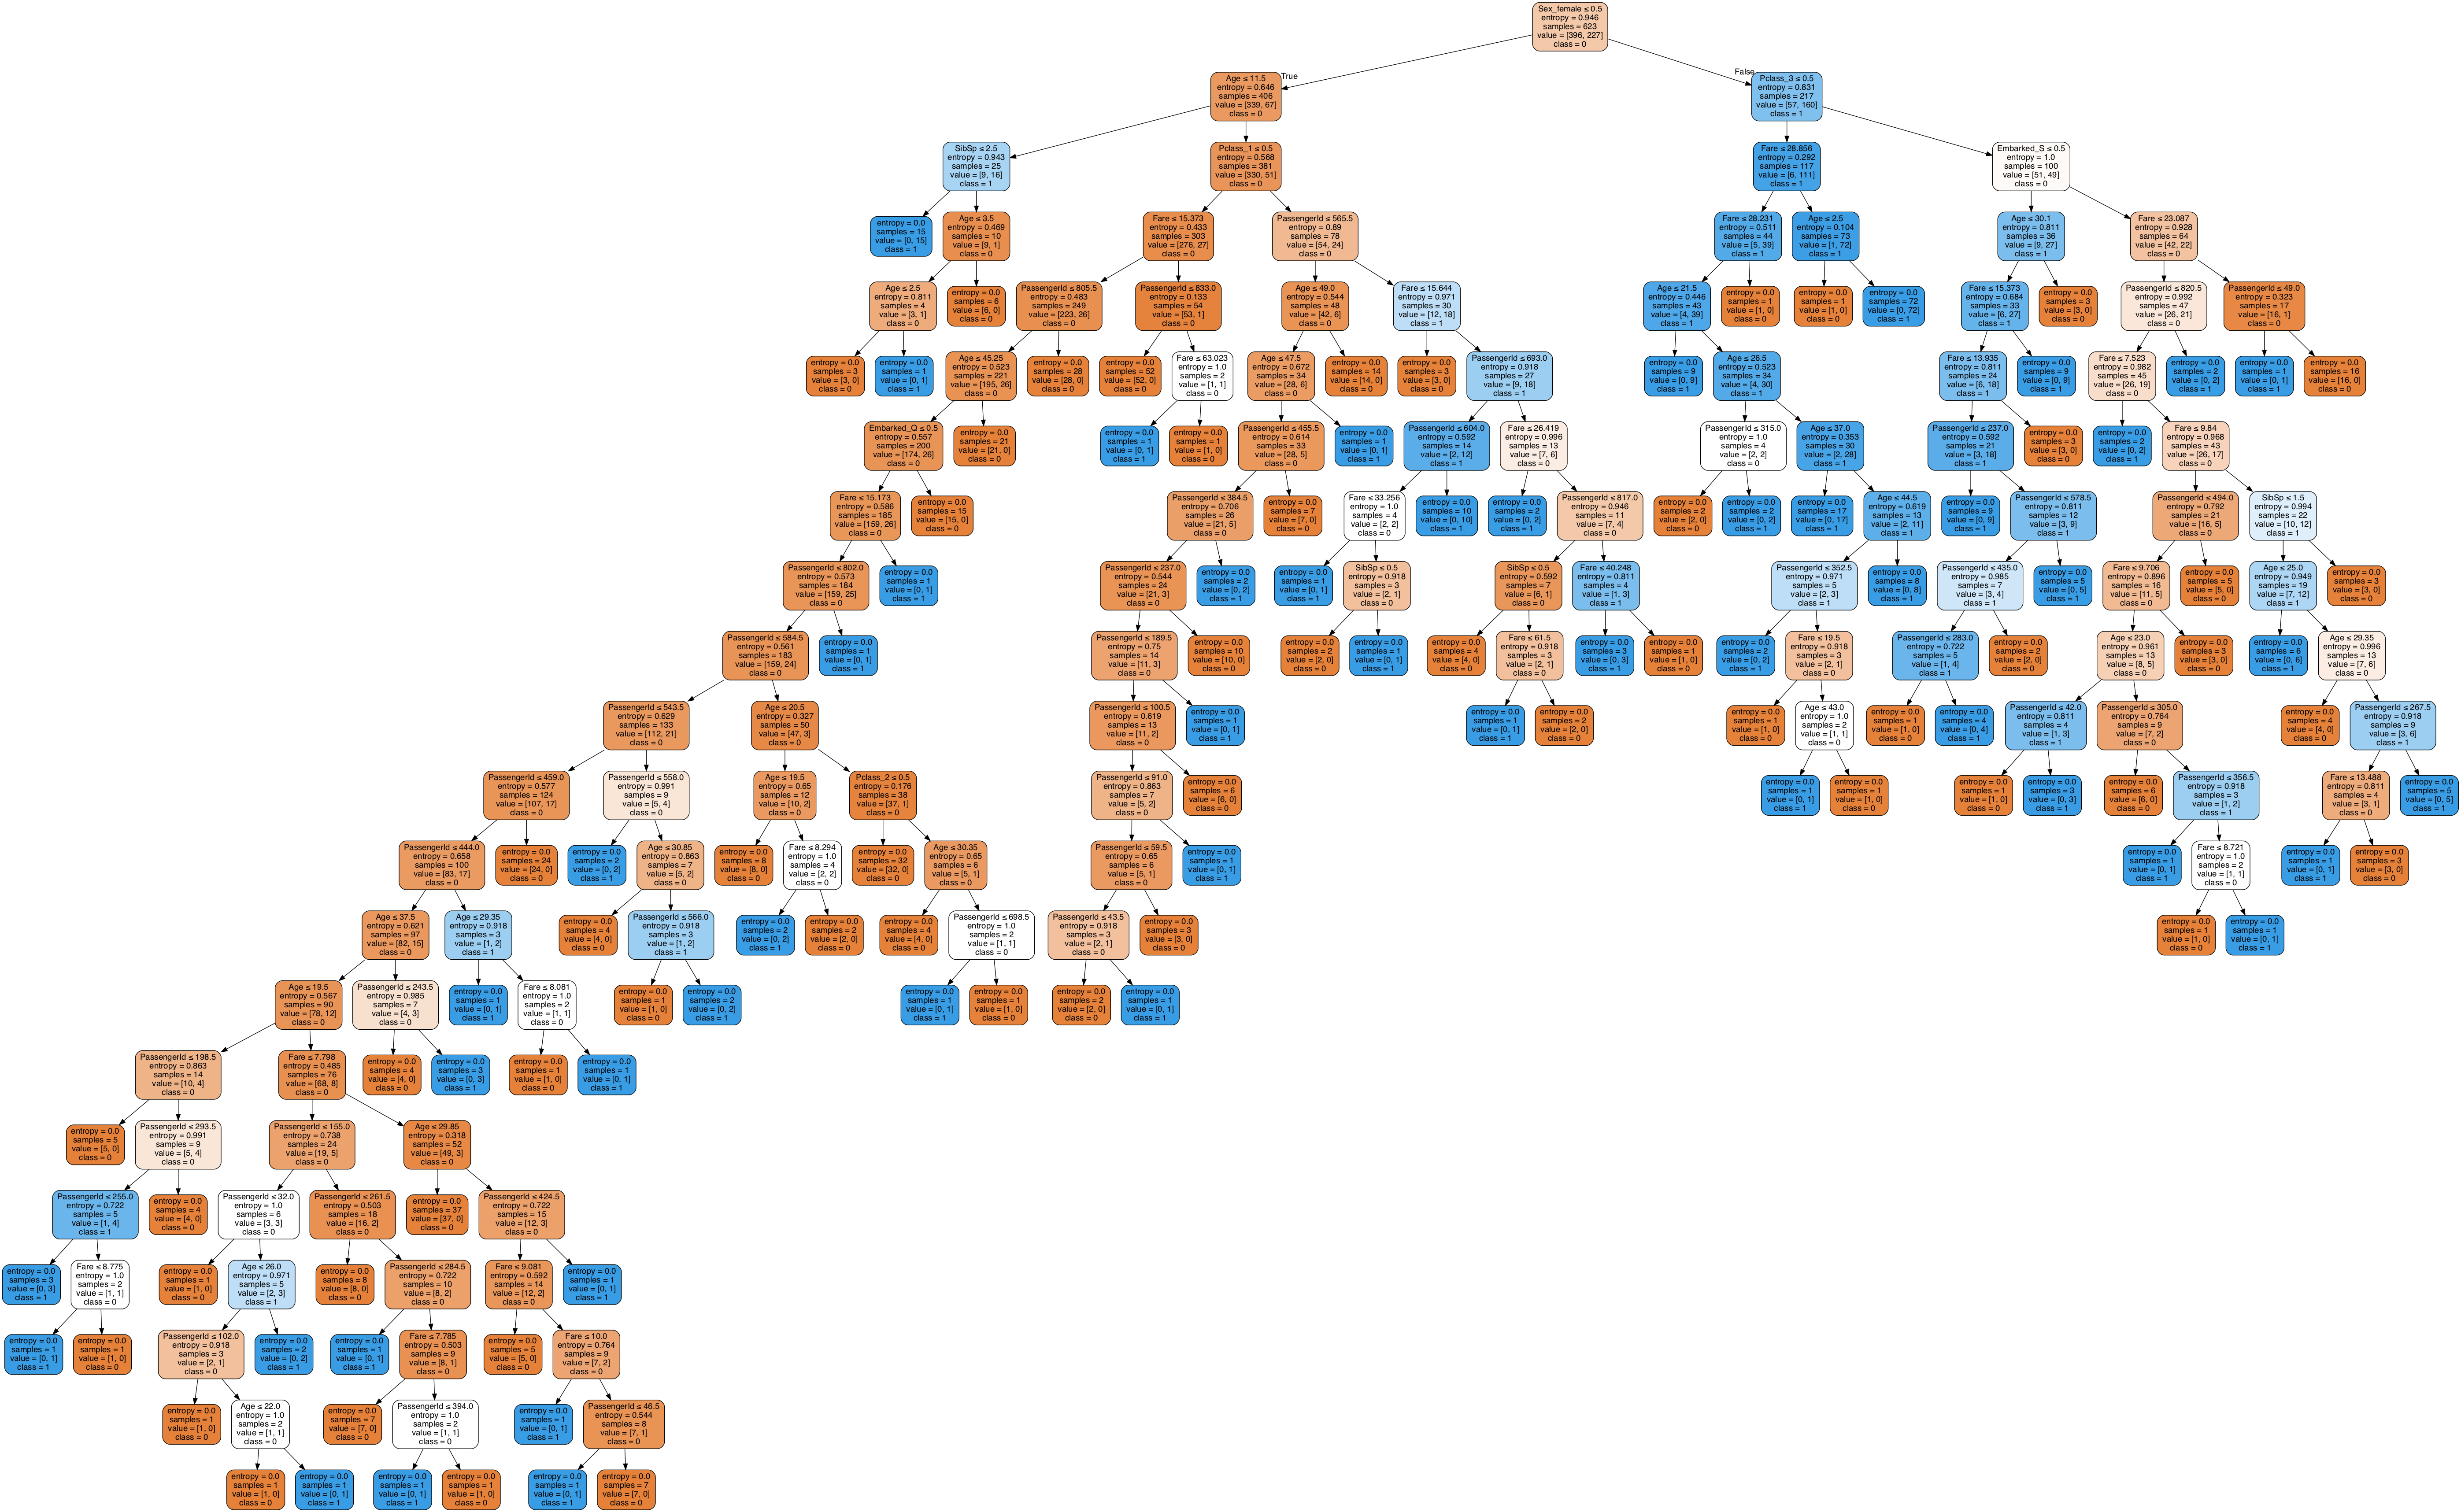

In [4]:
# Train the classifier using training data
dt = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
dt.fit(X_train, y_train)

# Create DOT data
dot_data = export_graphviz(
    dt, 
    out_file=None, 
    feature_names=X.columns,  
    class_names=np.unique(y).astype('str'), 
    filled=True, 
    rounded=True, 
    special_characters=True
)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## Make predictions 
- Create a set of predictions using the test set 
- Using `y_test` and `y_pred`, calculate the AUC (Area under the curve) to check the predictive performance

In [5]:
# Make predictions using test set 
y_hat_test = dt.predict(X_test)

In [6]:
def check_perf(y_test, y_hat_test, class_names, verbose=True):
    acc = accuracy_score(y_test, y_hat_test)*100
    if verbose:
        print('Accuracy is :{0}'.format(acc))

    # Check the AUC for predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    if verbose:
        print('\nAUC is :{0}'.format(round(roc_auc, 2)))

    if verbose:
        cnf_matrix = confusion_matrix(y_test, y_hat_test) # don't forget! 1st param is y true, second is y_hat

        # Create the basic matrix
        plt.imshow(cnf_matrix, cmap=plt.cm.Blues) 

        # Add title and axis labels
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        # Add appropriate axis scales
        #class_names = set(y) # Get class labels to add to matrix
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        # Add labels to each cell
        thresh = cnf_matrix.max() / 2. # Used for text coloring below
        # Here we iterate through the confusion matrix and append labels to our visualization 
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(
                j, 
                i, 
                cnf_matrix[i, j],
                horizontalalignment='center',
                color='white' if cnf_matrix[i, j] > thresh else 'black'
            )

        # Add a legend
        plt.colorbar()
        plt.grid(False)
        plt.show()

    return (roc_auc, false_positive_rate, true_positive_rate, thresholds)

Accuracy is :74.25373134328358

AUC is :0.73


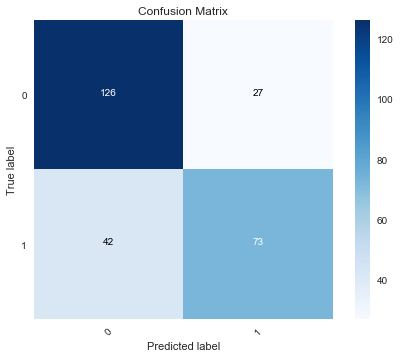

In [7]:
# Check the AUC of predictions
roc_auc_vanilla, false_positive_rate, true_positive_rate, thresholds = check_perf(y_test, y_hat_test, set(y))

## Maximum Tree Depth

Let's first check for the best depth parameter for our decision tree: 

- Create an array for `max_depth` values ranging from 1 - 32  
- In a loop, train the classifier for each depth value (32 runs) 
- Calculate the training and test AUC for each run 
- Plot a graph to show under/overfitting and the optimal value 
- Interpret the results 

In [8]:
def optimize_decision_tree(X_train, y_train, X_test, y_test, class_names, hp):

    roc_aucs_train = []
    roc_aucs_test = []

    best_roc_auc_test = None

    print(f"finding optimal {hp[0]} hyper-parameter value from {hp[1]}...")

    for hp_val in hp[1]:
        if hp[0] == 'max_depth':
            dt = DecisionTreeClassifier(criterion='entropy', max_depth=hp_val, random_state=SEED)
        elif hp[0] == 'min_samples_split':
            dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=hp_val, random_state=SEED)
        elif hp[0] == 'min_samples_leaf':
            dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=hp_val, random_state=SEED)
        elif hp[0] == 'max_features':
            dt = DecisionTreeClassifier(criterion='entropy', max_features=hp_val, random_state=SEED)
        else:
            print(f"hyper-parameter '{hp[0]}' is not supported!")
            return

        dt.fit(X_train, y_train)

        # train
        y_hat_train = dt.predict(X_train) 
        roc_auc, false_positive_rate, true_positive_rate, thresholds = check_perf(y_train, y_hat_train, class_names, verbose=False)
        roc_aucs_train.append(roc_auc)

        # test
        y_hat_test = dt.predict(X_test) 
        roc_auc, false_positive_rate, true_positive_rate, thresholds = check_perf(y_test, y_hat_test, class_names, verbose=False)
        roc_aucs_test.append(roc_auc)

        if best_roc_auc_test is None or roc_auc > best_roc_auc_test[1]:
            best_roc_auc_test = (hp_val, roc_auc)

    fig = plt.figure(figsize=(12,10))
    plt.plot(hp[1], roc_aucs_train, c='b', label='Train AUC')
    plt.plot(hp[1], roc_aucs_test, c='r', label='Test AUC')
    s_optimal_hp_val = f"optimal {hp[0]}: {best_roc_auc_test[0]}, test AUC: {best_roc_auc_test[1]}"
    plt.axvline(best_roc_auc_test[0], linestyle='--', c='black', label=s_optimal_hp_val)
    plt.ylabel('AUC score')
    plt.xlabel('Tree depth')
    plt.legend()
    fig.tight_layout()
    plt.show()

    print(s_optimal_hp_val)

    return best_roc_auc_test

finding optimal max_depth hyper-parameter value from [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]...


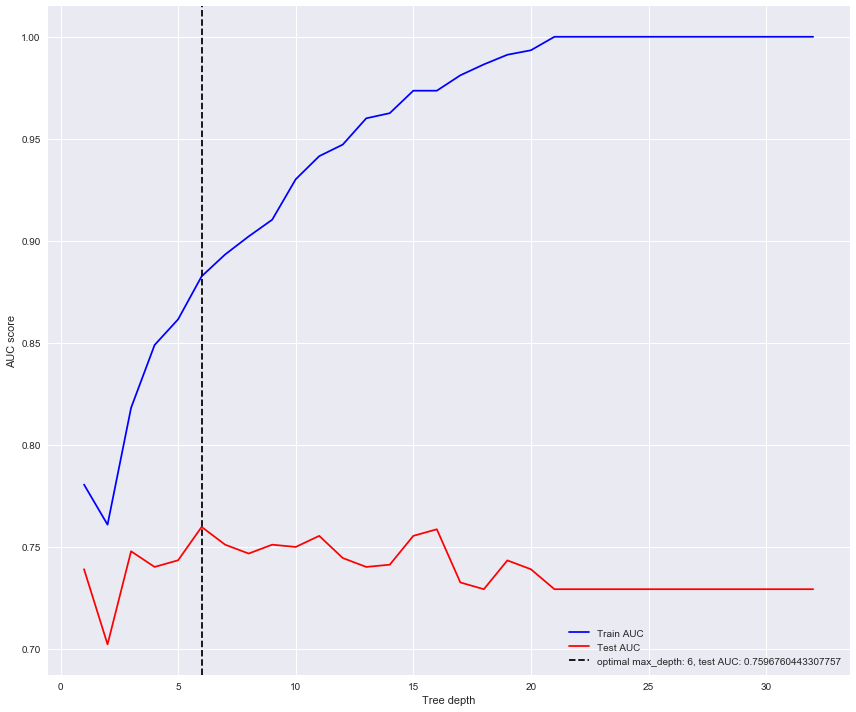

optimal max_depth: 6, test AUC: 0.7596760443307757


In [9]:
max_depths = np.array(list(range(1,33)))
best_roc_auc_test = optimize_decision_tree(X_train, y_train, X_test, y_test, set(y), ('max_depth', max_depths))
optimal_max_depth = best_roc_auc_test[0]

In [10]:
# You observations here 

# According to the "ROC Curves and AUC" lesson:
#   "... the Receiver Operating Characteristic curve (ROC) which graphs the False Positive Rate against the True Positive Rate. The overall accuracy of a classifier can thus be quantified by the AUC, the Area Under the Curve."

# Thus, since we want to find the max depth which produces the max AUC on the training set, that occurs with max depth == 6, which produces test AUC: 0.7596760443307757

## Minimum Sample Split

Now check for the best `min_samples_splits` parameter for our decision tree 

- Create an array for `min_sample_splits` values ranging from 0.1 - 1 with an increment of 0.1 
- In a loop, train the classifier for each `min_samples_splits` value (10 runs) 
- Calculate the training and test AUC for each run 
- Plot a graph to show under/overfitting and the optimal value 
- Interpret the results

finding optimal min_samples_split hyper-parameter value from [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]...


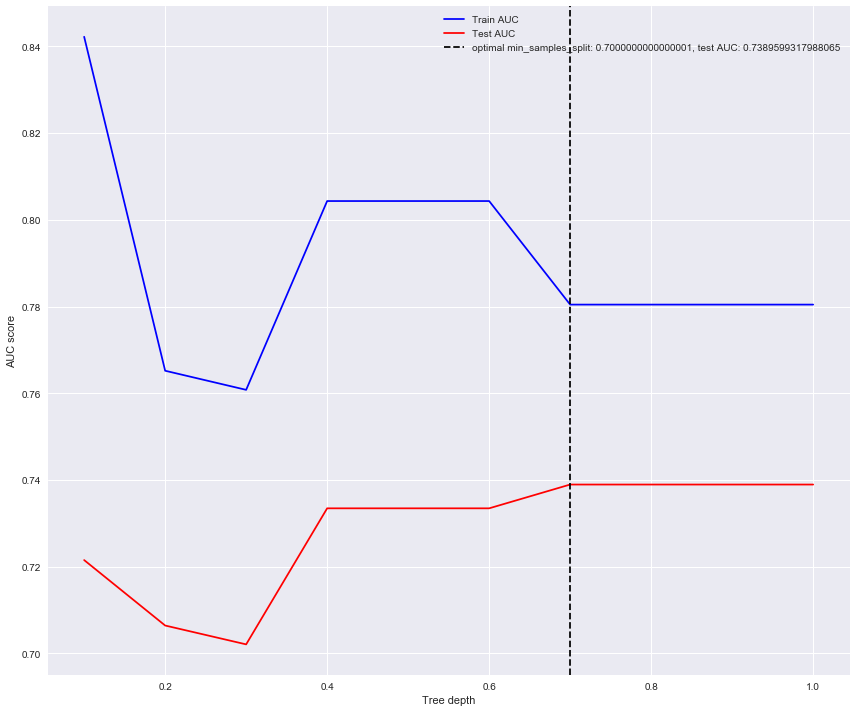

optimal min_samples_split: 0.7000000000000001, test AUC: 0.7389599317988065


In [11]:
# Identify the optimal min-samples-split for given data
incremement = 0.1
start = 0.1
stop = 1
min_samples_splits = np.linspace(start, stop, int(stop/incremement), endpoint=True)
best_roc_auc_test = optimize_decision_tree(X_train, y_train, X_test, y_test, set(y), ('min_samples_split', min_samples_splits))
optimal_min_samples_split = best_roc_auc_test[0]

In [12]:
# Your observations here

# the optimal min_samples split that maximizes AUC on the test set is 0.7

## Minimum Sample Leafs

Now check for the best `min_samples_leafs` parameter value for our decision tree 

- Create an array for `min_samples_leafs` values ranging from 0.1 - 0.5 with an increment of 0.1 
- In a loop, train the classifier for each `min_samples_leafs` value (5 runs) 
- Calculate the training and test AUC for each run 
- Plot a graph to show under/overfitting and the optimal value 
- Interpret the results

finding optimal min_samples_leaf hyper-parameter value from [0.1 0.2 0.3 0.4 0.5]...


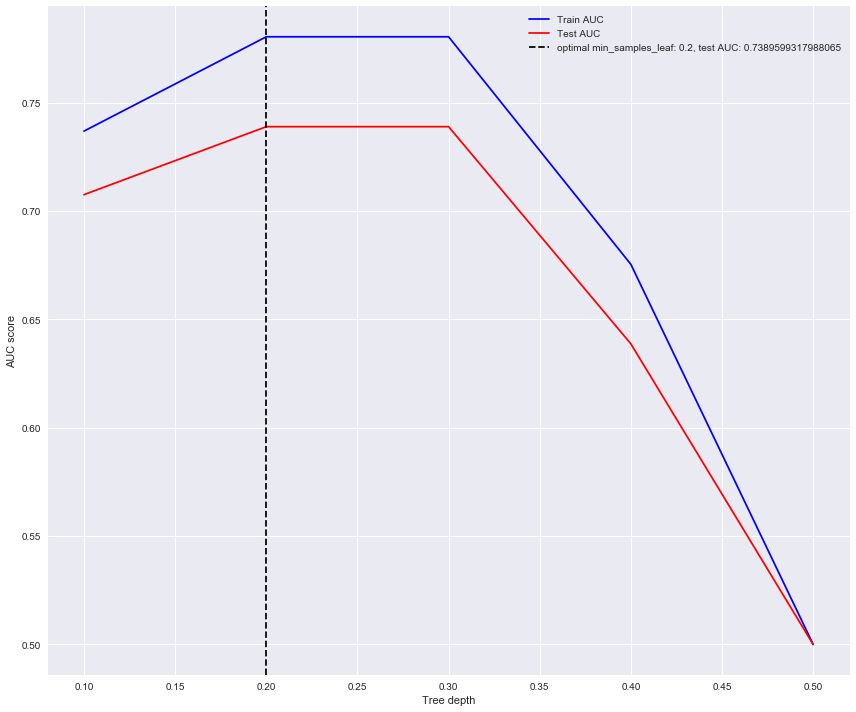

optimal min_samples_leaf: 0.2, test AUC: 0.7389599317988065


In [13]:
# Calculate the optimal value for minimum sample leafs

incremement = 0.1
start = 0.1
stop = 0.5
min_samples_leaves = np.linspace(start, stop, int(stop/incremement), endpoint=True)
best_roc_auc_test = optimize_decision_tree(X_train, y_train, X_test, y_test, set(y), ('min_samples_leaf', min_samples_leaves))
optimal_min_samples_leaf = best_roc_auc_test[0]

In [14]:
# Your observations here 

# the optimal min_samples_leaf that maximizes AUC on the test set is 0.2

## Maximum Features

Now check for the best `max_features` parameter value for our decision tree 

- Create an array for `max_features` values ranging from 1 - 12 (1 feature vs all)
- In a loop, train the classifier for each `max_features` value (12 runs) 
- Calculate the training and test AUC for each run 
- Plot a graph to show under/overfitting and the optimal value 
- Interpret the results

finding optimal max_features hyper-parameter value from [ 1  2  3  4  5  6  7  8  9 10 11 12]...


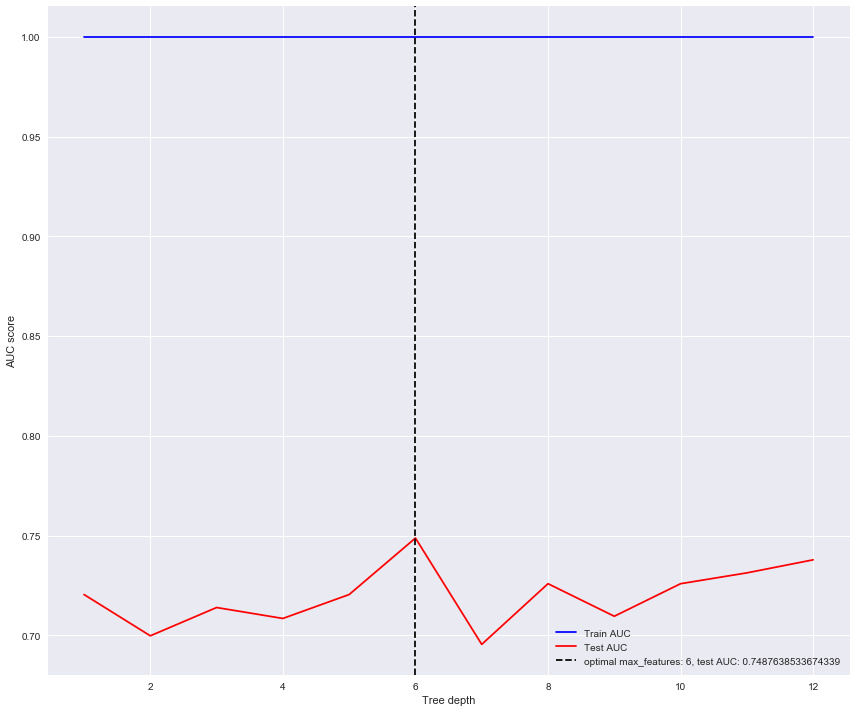

optimal max_features: 6, test AUC: 0.7487638533674339


In [15]:
# Find the best value for optimal maximum feature size

max_features = np.array(list(range(1,13)))
best_roc_auc_test = optimize_decision_tree(X_train, y_train, X_test, y_test, set(y), ('max_features', max_features))
optimal_max_features = best_roc_auc_test[0]

In [16]:
# Your observations here

# the optimal max_features that maximizes AUC on the test set is 6

## Re-train the classifier with chosen values

Now we will use the best values from each training phase above and feed it back to our classifier. Then we can see if there is any improvement in predictive performance. 

- Train the classifier with the optimal values identified 
- Compare the AUC of the new model with the earlier vanilla decision tree AUC 
- Interpret the results of the comparison

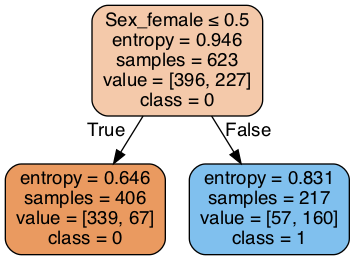

In [17]:
# Train a classifier with optimal values identified above
dt = dt = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=optimal_max_depth, 
    min_samples_split=optimal_min_samples_split,
    min_samples_leaf=optimal_min_samples_leaf,
    max_features=optimal_max_features,
    random_state=SEED
)
dt.fit(X_train, y_train)

# Create DOT data
dot_data = export_graphviz(
    dt, 
    out_file=None, 
    feature_names=X.columns,  
    class_names=np.unique(y).astype('str'), 
    filled=True, 
    rounded=True, 
    special_characters=True
)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

Accuracy is :75.3731343283582

AUC is :0.74


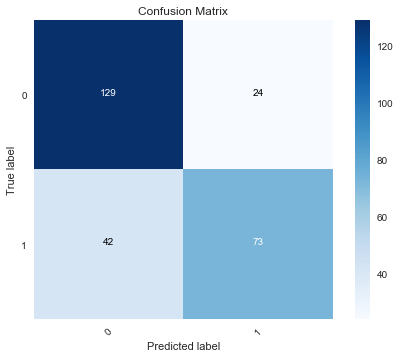

'vanilla' AUC: 0.729156010230179, AUC of final/optimized model: 0.7389599317988065


In [18]:
y_hat_test = dt.predict(X_test)
roc_auc_final, false_positive_rate, true_positive_rate, thresholds = check_perf(y_test, y_hat_test, set(y))

print(f"'vanilla' AUC: {roc_auc_vanilla}, AUC of final/optimized model: {roc_auc_final}")

In [19]:
# You observations here

# the AUC of the final model is obviously better than the AUC of the first, vanilla model

In the next section, we shall talk about hyperparameter tuning using a technique called "grid-search" to make this process even more granular and decisive. 

## Summary 

In this lesson, we looked at tuning a decision tree classifier in order to avoid overfitting and increasing the generalization capabilities of the classifier. For the titanic dataset, we see that identifying optimal parameter values can result in some improvements towards predictions. This idea will be exploited further in upcoming lessons and labs. 